In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

32952


In [2]:
from matplotlib.colors import LogNorm
from ImageAnalysis3.figure_tools import _dpi,_single_col_width,_double_col_width,_single_row_height,_ref_bar_length, _ticklabel_size,_ticklabel_width,_font_size
plt.style.use('dark_background')

figure_master_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220803-Figures'
contact_figure_folder = os.path.join(figure_master_folder, 'LongRangeContacts')
if not os.path.exists(contact_figure_folder):
    print(f"Create contact_figure_folder: {contact_figure_folder}")
    os.makedirs(contact_figure_folder)
else:
    print(f"Use contact_figure_folder: {contact_figure_folder}")
comp_figure_folder = os.path.join(figure_master_folder, 'AB_compartments')
if not os.path.exists(comp_figure_folder):
    print(f"Create comp_figure_folder: {comp_figure_folder}")
    os.makedirs(comp_figure_folder)
else:
    print(f"Use comp_figure_folder: {comp_figure_folder}")

Use contact_figure_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220803-Figures\LongRangeContacts
Use comp_figure_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220803-Figures\AB_compartments


In [3]:
merged_data_folder = r'\\crick\SSD_0\Shiwei\DNA_MERFISH_analysis\20220402plus0316_MERFISH'
print(merged_data_folder)
# 
postanalysis_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis'
print(postanalysis_folder)

\\crick\SSD_0\Shiwei\DNA_MERFISH_analysis\20220402plus0316_MERFISH
\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis


## Load codebook

In [4]:
import pandas as pd
codebook = pd.read_csv(os.path.join(merged_data_folder, 'merged_codebook_w_celltype.csv'))
bit_columns = [_n for _n in codebook.columns if 'NDB' in _n]

In [5]:
sort_by_region = False
from ImageAnalysis3.structure_tools import distance

chr_2_indices, chr_2_orders = distance.Generate_PlotOrder(codebook, codebook, sort_by_region=sort_by_region)

## Load coordinates for subtypes

In [6]:
class_2_zxysDict = np.load(os.path.join(merged_data_folder, 'merged_class_2_chr_zxys.pkl'), allow_pickle=True)

# 1. calculate overall AB density for ensemble AB calling

In [7]:
# output from previous AB calling
subclass_2_normedPC1_filename = os.path.join(postanalysis_folder, 'subclass_2_normedPC1.pkl')
subclass_2_normedMat_filename = os.path.join(postanalysis_folder, 'subclass_2_normedMat.pkl')
subclass_2_corrMat_filename = os.path.join(postanalysis_folder, 'subclass_2_corrMat.pkl')


In [8]:
import pandas as pd
pc1_df = pd.read_csv(subclass_2_normedPC1_filename.replace('.pkl', '.csv'))

In [11]:
# define AB
ensemble_AB_dict = {}
AB_th = -0.5
ensemble_AB_dict['A'] = np.where(pc1_df['ensemble'].values > AB_th)[0]
ensemble_AB_dict['B'] = np.where(pc1_df['ensemble'].values <= AB_th)[0]
# by chr
ensemble_chr_2_AB = {}
for _chr in chr_2_indices:
    _chr_AB = {
        'A':np.array([list(chr_2_indices[_chr]).index(_ind) 
                      for _ind in np.intersect1d(chr_2_indices[_chr], ensemble_AB_dict['A'])], dtype=np.int32),
        'B':np.array([list(chr_2_indices[_chr]).index(_ind) 
                      for _ind in np.intersect1d(chr_2_indices[_chr], ensemble_AB_dict['B'])], dtype=np.int32),
    }
    ensemble_chr_2_AB[_chr] = _chr_AB

In [43]:
from tqdm import tqdm
from ImageAnalysis3.compartment_tools.density import BatchCompartmentDensities
reload(ia.compartment_tools.density)

<module 'ImageAnalysis3.compartment_tools.density' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\compartment_tools\\density.py'>

In [13]:
gaussian_radius = 500 # nm
normalize_by_reg_num = False

subclass_2_transScoreDicts = {}
subclass_2_cisScoreDicts = {}
for _sel_class in class_2_zxysDict:
    print(_sel_class, end =' ')
    _class_start = time.time()
    subclass_2_transScoreDicts[_sel_class] = BatchCompartmentDensities(
        class_2_zxysDict[_sel_class], ensemble_chr_2_AB, gaussian_radius, normalize_by_reg_num=normalize_by_reg_num,)
    subclass_2_cisScoreDicts[_sel_class] = BatchCompartmentDensities(
        class_2_zxysDict[_sel_class], ensemble_chr_2_AB, gaussian_radius, normalize_by_reg_num=normalize_by_reg_num,
        use_cis=True, use_trans=False)
    #
    print(f"in {time.time()-_class_start:.2f}s. ")

Astro in 400.55s. 
Endo-PVM in 336.29s. 
L2/3 IT in 390.21s. 
L4/5 IT in 294.68s. 
L5 ET in 191.43s. 
L5 IT in 302.74s. 
L5/6 NP in 128.50s. 
L6 CT in 823.87s. 
L6 IT in 295.35s. 
L6b in 119.66s. 
Lamp5 in 82.36s. 
Micro in 284.00s. 
OPC in 266.63s. 
Oligo in 740.54s. 
Peri in 111.45s. 
Pvalb in 157.35s. 
SMC in 98.70s. 
Sncg in 31.04s. 
Sst in 104.68s. 
VLMC in 54.67s. 
Vip in 60.90s. 


In [45]:
cisABscores_ensemble_filename = os.path.join(postanalysis_folder, f'cisABscores_ensembleAB_notNorm_r{gaussian_radius}.pkl')
if not os.path.exists(cisABscores_ensemble_filename):
    print(cisABscores_ensemble_filename)
    pickle.dump(subclass_2_cisScoreDicts, open(cisABscores_ensemble_filename, 'wb'))

\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis\cisABscores_ensembleAB_notNorm_r500.pkl


In [51]:
transABscores_ensemble_filename = os.path.join(postanalysis_folder, f'transABscores_ensembleAB_notNorm_r{gaussian_radius}.pkl')
if not os.path.exists(transABscores_ensemble_filename):
    print(transABscores_ensemble_filename)
    pickle.dump(subclass_2_transScoreDicts, open(transABscores_ensemble_filename, 'wb'))

\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis\transABscores_ensembleAB_notNorm_r500.pkl


In [32]:
# convert into dict
subclass_2_cisABRatioDicts = {}
# loop
for _class, _scoreDicts in subclass_2_cisScoreDicts.items():
    print(_class, len(_scoreDicts))
    
    _ABratioDicts = [] 
    for _scoreDict in _scoreDicts:
        _chr_2_abratios = {}
        for _chr, _chr_AB_dict in _scoreDict.items():
            _AB_ratios = np.log(_chr_AB_dict['A']) - np.log(_chr_AB_dict['B'])
            _chr_2_abratios[_chr] = _AB_ratios
        # append
        _ABratioDicts.append(_chr_2_abratios)
    # assign
    subclass_2_cisABRatioDicts[_class] = _ABratioDicts

Astro 2533


C:\Users\puzheng\AppData\Local\Temp\2\ipykernel_32952\1529826489.py:11: RuntimeWarning: divide by zero encountered in log
  _AB_ratios = np.log(_chr_AB_dict['A']) - np.log(_chr_AB_dict['B'])
C:\Users\puzheng\AppData\Local\Temp\2\ipykernel_32952\1529826489.py:11: RuntimeWarning: invalid value encountered in subtract
  _AB_ratios = np.log(_chr_AB_dict['A']) - np.log(_chr_AB_dict['B'])


Endo-PVM 1663
L2/3 IT 2358
L4/5 IT 1606
L5 ET 833
L5 IT 1289
L5/6 NP 457
L6 CT 3078
L6 IT 1159
L6b 408
Lamp5 282
Micro 877
OPC 989
Oligo 2417


C:\Users\puzheng\AppData\Local\Temp\2\ipykernel_32952\1529826489.py:11: RuntimeWarning: invalid value encountered in double_scalars
  _AB_ratios = np.log(_chr_AB_dict['A']) - np.log(_chr_AB_dict['B'])


Peri 338
Pvalb 825
SMC 471
Sncg 138
Sst 599
VLMC 252
Vip 283


In [46]:
cisABratio_ensemble_filename = os.path.join(postanalysis_folder, f'cisABRatio_ensembleAB_notNorm_r{gaussian_radius}.pkl')
if not os.path.exists(cisABratio_ensemble_filename):
    print(cisABratio_ensemble_filename)
    pickle.dump(subclass_2_cisABRatioDicts, open(cisABratio_ensemble_filename, 'wb'))

In [49]:
# convert into dict
subclass_2_transABRatioDicts = {}
# loop
for _class, _scoreDicts in subclass_2_transScoreDicts.items():
    print(_class, len(_scoreDicts))
    
    _ABratioDicts = [] 
    for _scoreDict in _scoreDicts:
        _chr_2_abratios = {}
        for _chr, _chr_AB_dict in _scoreDict.items():
            _AB_ratios = np.log(_chr_AB_dict['A']) - np.log(_chr_AB_dict['B'])
            _chr_2_abratios[_chr] = _AB_ratios
        # append
        _ABratioDicts.append(_chr_2_abratios)
    # assign
    subclass_2_transABRatioDicts[_class] = _ABratioDicts

Astro 2533
Endo-PVM 1663
L2/3 IT 2358
L4/5 IT 1606
L5 ET 833
L5 IT 1289
L5/6 NP 457
L6 CT 3078
L6 IT 1159
L6b 408
Lamp5 282
Micro 877
OPC 989
Oligo 2417


C:\Users\puzheng\AppData\Local\Temp\2\ipykernel_32952\932551879.py:11: RuntimeWarning: divide by zero encountered in log
  _AB_ratios = np.log(_chr_AB_dict['A']) - np.log(_chr_AB_dict['B'])
C:\Users\puzheng\AppData\Local\Temp\2\ipykernel_32952\932551879.py:11: RuntimeWarning: invalid value encountered in double_scalars
  _AB_ratios = np.log(_chr_AB_dict['A']) - np.log(_chr_AB_dict['B'])


Peri 338
Pvalb 825
SMC 471
Sncg 138
Sst 599
VLMC 252
Vip 283


In [50]:
transABratio_ensemble_filename = os.path.join(postanalysis_folder, f'transABRatio_ensembleAB_notNorm_r{gaussian_radius}.pkl')
if not os.path.exists(transABratio_ensemble_filename):
    print(transABratio_ensemble_filename)
    pickle.dump(subclass_2_transABRatioDicts, open(transABratio_ensemble_filename, 'wb'))

\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis\transABRatio_ensembleAB_notNorm_r500.pkl


In [41]:
gaussian_radius

500

# Normalized version

In [52]:
from tqdm import tqdm
from ImageAnalysis3.compartment_tools.density import BatchCompartmentDensities
reload(ia.compartment_tools.density)

<module 'ImageAnalysis3.compartment_tools.density' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\compartment_tools\\density.py'>

In [53]:
gaussian_radius = 500 # nm
normalize_by_reg_num = True

subclass_2_transScoreDicts = {}
subclass_2_cisScoreDicts = {}
for _sel_class in class_2_zxysDict:
    print(_sel_class, end =' ')
    _class_start = time.time()
    subclass_2_transScoreDicts[_sel_class] = BatchCompartmentDensities(
        class_2_zxysDict[_sel_class], ensemble_chr_2_AB, gaussian_radius, normalize_by_reg_num=normalize_by_reg_num,)
    subclass_2_cisScoreDicts[_sel_class] = BatchCompartmentDensities(
        class_2_zxysDict[_sel_class], ensemble_chr_2_AB, gaussian_radius, normalize_by_reg_num=normalize_by_reg_num,
        use_cis=True, use_trans=False)
    #
    print(f"in {time.time()-_class_start:.2f}s. ")

Astro in 417.95s. 
Endo-PVM in 331.93s. 
L2/3 IT in 344.71s. 
L4/5 IT in 247.47s. 
L5 ET in 119.92s. 
L5 IT in 188.09s. 
L5/6 NP in 85.10s. 
L6 CT in 526.81s. 
L6 IT in 190.39s. 
L6b in 81.71s. 
Lamp5 in 56.96s. 
Micro in 194.87s. 
OPC in 182.51s. 
Oligo in 490.81s. 
Peri in 79.73s. 
Pvalb in 142.83s. 
SMC in 101.98s. 
Sncg in 31.79s. 
Sst in 104.53s. 
VLMC in 52.58s. 
Vip in 54.56s. 


In [54]:
cisABscores_ensemble_filename = os.path.join(postanalysis_folder, f'cisABscores_ensembleAB_Norm_r{gaussian_radius}.pkl')
if not os.path.exists(cisABscores_ensemble_filename):
    print(cisABscores_ensemble_filename)
    pickle.dump(subclass_2_cisScoreDicts, open(cisABscores_ensemble_filename, 'wb'))
transABscores_ensemble_filename = os.path.join(postanalysis_folder, f'transABscores_ensembleAB_Norm_r{gaussian_radius}.pkl')
if not os.path.exists(transABscores_ensemble_filename):
    print(transABscores_ensemble_filename)
    pickle.dump(subclass_2_transScoreDicts, open(transABscores_ensemble_filename, 'wb'))

\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis\cisABscores_ensembleAB_Norm_r500.pkl
\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis\transABscores_ensembleAB_Norm_r500.pkl


In [55]:
# convert into dict
subclass_2_cisABRatioDicts = {}
# loop
for _class, _scoreDicts in subclass_2_cisScoreDicts.items():
    print(_class, len(_scoreDicts))
    
    _ABratioDicts = [] 
    for _scoreDict in _scoreDicts:
        _chr_2_abratios = {}
        for _chr, _chr_AB_dict in _scoreDict.items():
            _AB_ratios = np.log(_chr_AB_dict['A']) - np.log(_chr_AB_dict['B'])
            _chr_2_abratios[_chr] = _AB_ratios
        # append
        _ABratioDicts.append(_chr_2_abratios)
    # assign
    subclass_2_cisABRatioDicts[_class] = _ABratioDicts

Astro 2533
Endo-PVM 1663
L2/3 IT 2358
L4/5 IT 1606
L5 ET 833
L5 IT 1289
L5/6 NP 457
L6 CT 3078
L6 IT 1159
L6b 408
Lamp5 282
Micro 877
OPC 989
Oligo 2417


C:\Users\puzheng\AppData\Local\Temp\2\ipykernel_32952\3846046256.py:11: RuntimeWarning: divide by zero encountered in log
  _AB_ratios = np.log(_chr_AB_dict['A']) - np.log(_chr_AB_dict['B'])
C:\Users\puzheng\AppData\Local\Temp\2\ipykernel_32952\3846046256.py:11: RuntimeWarning: invalid value encountered in double_scalars
  _AB_ratios = np.log(_chr_AB_dict['A']) - np.log(_chr_AB_dict['B'])


Peri 338
Pvalb 825
SMC 471
Sncg 138
Sst 599
VLMC 252
Vip 283


In [56]:
cisABratio_ensemble_filename = os.path.join(postanalysis_folder, f'cisABRatio_ensembleAB_Norm_r{gaussian_radius}.pkl')
if not os.path.exists(cisABratio_ensemble_filename):
    print(cisABratio_ensemble_filename)
    pickle.dump(subclass_2_cisABRatioDicts, open(cisABratio_ensemble_filename, 'wb'))

\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis\cisABRatio_ensembleAB_Norm_r500.pkl


In [57]:
# convert into dict
subclass_2_transABRatioDicts = {}
# loop
for _class, _scoreDicts in subclass_2_transScoreDicts.items():
    print(_class, len(_scoreDicts))
    
    _ABratioDicts = [] 
    for _scoreDict in _scoreDicts:
        _chr_2_abratios = {}
        for _chr, _chr_AB_dict in _scoreDict.items():
            _AB_ratios = np.log(_chr_AB_dict['A']) - np.log(_chr_AB_dict['B'])
            _chr_2_abratios[_chr] = _AB_ratios
        # append
        _ABratioDicts.append(_chr_2_abratios)
    # assign
    subclass_2_transABRatioDicts[_class] = _ABratioDicts

Astro 2533
Endo-PVM 1663
L2/3 IT 2358
L4/5 IT 1606
L5 ET 833
L5 IT 1289
L5/6 NP 457
L6 CT 3078
L6 IT 1159
L6b 408
Lamp5 282
Micro 877
OPC 989
Oligo 2417


C:\Users\puzheng\AppData\Local\Temp\2\ipykernel_32952\932551879.py:11: RuntimeWarning: divide by zero encountered in log
  _AB_ratios = np.log(_chr_AB_dict['A']) - np.log(_chr_AB_dict['B'])
C:\Users\puzheng\AppData\Local\Temp\2\ipykernel_32952\932551879.py:11: RuntimeWarning: invalid value encountered in double_scalars
  _AB_ratios = np.log(_chr_AB_dict['A']) - np.log(_chr_AB_dict['B'])


Peri 338
Pvalb 825
SMC 471
Sncg 138
Sst 599
VLMC 252
Vip 283


In [58]:
transABratio_ensemble_filename = os.path.join(postanalysis_folder, f'transABRatio_ensembleAB_Norm_r{gaussian_radius}.pkl')
if not os.path.exists(transABratio_ensemble_filename):
    print(transABratio_ensemble_filename)
    pickle.dump(subclass_2_transABRatioDicts, open(transABratio_ensemble_filename, 'wb'))

\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis\transABRatio_ensembleAB_Norm_r500.pkl


<IPython.core.display.Javascript object>


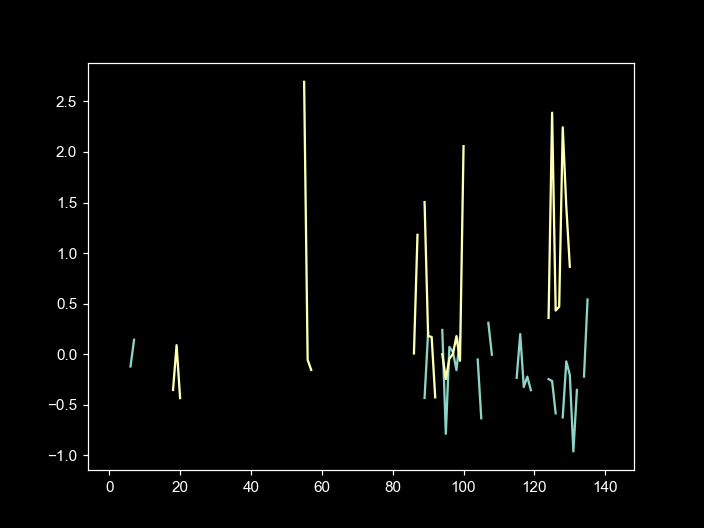

In [63]:
plt.plot(subclass_2_transABRatioDicts['Astro'][0]['2'].transpose())